In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tabulate import tabulate

# Acquisition

|          | Description                                                  |         Amount |
| -------- | ------------------------------------------------------------ | -------------: |
| nodes    | mice                                                         |      100 - 200 |
| edges    | similar genes, protein expressions, or phenotypes            | O(10) per node |
| features | genes, protein expressions in tissues, or phenotypes         |          1000s |
| labels   | depends: a particular gene, phenotype, or protein expression |            N/A |

## Loading

### genotype_BXD

In [9]:
genotype_df = pd.read_csv("data/genotype_BXD.txt", sep='\t', index_col='SNP')

In [10]:
# Remove F0 and F1 generation (parental)
genotype_df.drop(['B6D2F1', 'D2B6F1', 'C57BL.6J', 'DBA.2J'], axis=1, inplace=True)

In [11]:
genotype_df = genotype_df.transpose()
genotype_df.index.name = 'BXD_strain'

In [12]:
print("There is NaN values: %s" % genotype_df.isna().any().any())

There is NaN values: False


In [13]:
genotype_df.head()

SNP,rs31443144,rs6269442,rs32285189,rs258367496,rs32430919,rs36251697,rs30658298,rs51852623,rs31879829,rs36742481,...,rs47382998,rs13484107,rs3693969,DXMit223,rs31638776,rs31639754,rs46326766,rs31412493,rs31417520,UT-M-9461
BXD_strain,,,,,,,,,,,,,,,,,,,,,
BXD1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,1,1,-1
BXD2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,1,1,-1
BXD5,1,1,1,1,1,1,1,1,1,1,...,-1,-1,-1,-1,-1,-1,1,1,1,-1
BXD6,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,-1
BXD8,1,1,1,1,1,1,1,1,1,1,...,-1,-1,-1,-1,-1,-1,1,1,1,-1


### Phenotype

In [55]:
phenotype_df = pd.read_csv("data/Phenotype.txt", sep='\t', index_col='PhenoID')

In [56]:
# Remove F0 and F1 generation (parental)
phenotype_df.drop(['B6D2F1', 'D2B6F1', 'C57BL.6J', 'DBA.2J'], axis=1, inplace=True)

In [57]:
nan_count = phenotype_df.isna().sum().sum()
entries_count = phenotype_df.shape[0] * phenotype_df.shape[1]

print("Number of Nan values: %s" % nan_count)
print("Percentage of nan in the phenotype file: {:0.2f}%".format(nan_count / entries_count * 100))

Number of Nan values: 291981
Percentage of nan in the phenotype file: 61.66%


/Users/Raphael/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/matplotlib/axes/_axes.py:7847: RuntimeWarning: invalid value encountered in greater
  mask = np.abs(Z) > precision


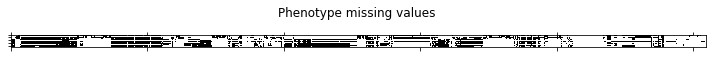

In [18]:
fig, ax = plt.subplots(figsize=(10, 1))
ax.spy(phenotype_df.T)
plt.suptitle("Phenotype missing values")
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.tight_layout()
plt.show()
fig.savefig("phenotype_missing_values.jpg")

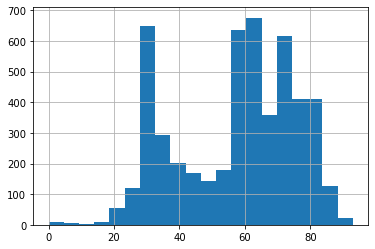

In [43]:
# Let's try to find phenotypes for which the maximum of mice have an entry
phenotype_df.isnull().sum(axis=1).hist(bins=20)

In [44]:
# Select label based on phenotype selection thank to phenotype_id_aligner
labels = phenotype_df.loc[['X62', 'X63', 'X64']].dropna(axis=1)

### Gene Expression

In [72]:
#Gene expression
__file__ = "Graph_Analysis_Mice_Genetics.ipynb"
import os
import re

# Build the frame for non sex-related phenotypes
current_path = os.path.dirname(os.path.abspath(__file__))
expr_data_path = os.path.join(current_path, 'data/expression_data/')
files = os.listdir(expr_data_path)
filtered_files = []
pattern = r'Female|Male'
for file in files:
    if re.search(pattern, file):
        continue
    else:
        filtered_files.append(file)

cat = []

for filename in filtered_files[:5]:
    df = pd.read_csv(os.path.join(expr_data_path, filename), sep='\t', index_col=None, header=0)
    cat.append(df)

frame = pd.concat(cat, axis=0, ignore_index=True)
frame.set_index('gene', inplace=True)
# Remove F0 and F1 generation (parental)
frame.drop(['B6D2F1', 'C57BL.6J', 'DBA.2J'], axis=1, inplace=True)

frame.to_pickle("data/pickle/concat_phenotypes.pkl")

Graph_Analysis_Mice_Genetics.ipynb:24: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  },


In [83]:
print("Percentage of missing values: %0.2f percent" % (frame.isna().sum().sum() / (frame.shape[0] * frame.shape[1]) * 100))

Percentage of missing values: 52.69 percent


In [119]:
# Keep only genes that are recorded for more than 33 mice
frame_nan_count = frame.isna().sum(axis=1)
filter_frame = frame[frame_nan_count == frame_nan_count.min()]

In [121]:
filter_frame = filter_frame.T

In [125]:
filter_frame.to_pickle("data/pickle/gene_expr.pkl")

### Phenotype_id_aligner

In [127]:
phenotype_id_aligner = pd.read_csv('data/phenotypes_id_aligner.txt', sep='\t', encoding='latin1')

phenotype_id_aligner.rename({'Quantitive.trait': 'quantitative_trait'}, axis=1, inplace=True)
quant_pheno_best = phenotype_id_aligner[(phenotype_id_aligner.Strains > 70) & (phenotype_id_aligner.quantitative_trait == 'No')]
quant_pheno_best = quant_pheno_best.sort_values(by='Strains', ascending=False)


In [128]:
quant_pheno_best.head()

,PhenoID,PhenoID.1,RecordID,Phenotype,Shown_pheno,Category,Category_ID,color,Phenotype_post,Phenotype_pre,Authors,Senior.Author,Abbreviation,quantitative_trait,Tissues,Diet,Strains
2587,X64,64,10678,"Skin, pigmentation: Hair coat color, ordinal s...","Hair coat color, ordinal scale version 1 black...",Morphology,2588.0,9.0,"Skin, pigmentation: Hair coat color, ordinal s...","Skin, pigmentation: Hair coat color, ordinal s...","Lu Lu, Jing Gu, Robert Williams",Williams,NaN,No,NaN,NaN,94
2627,X62,62,11280,"Skin, pigmentation: Hair coat color, ordinal s...","Hair coat color, ordinal scale version 2 where...",Morphology,2628.0,9.0,"Skin, pigmentation: Hair coat color, ordinal s...","Skin, pigmentation: Hair coat color, ordinal s...","Lu Lu, Jing Gu, Robert Williams",Williams,NaN,No,NaN,NaN,94
3078,X63,63,15571,"Skin, pigmentation: Hair coat color, ordinal s...","Hair coat color, ordinal scale version 3 where...",Morphology,3079.0,9.0,"Skin, pigmentation: Hair coat color, ordinal s...","Skin, pigmentation: Hair coat color, ordinal s...","Lu Lu, Jing Gu, Robert Williams",Williams,NaN,No,NaN,NaN,94
4740,X4473,4473,11300,"Metabolism, genetics: Mitochondrial strain ori...",Mitochondrial strain origin (-1 = C57BL/6J and...,Other,4741.0,12.0,"Metabolism, genetics: Mitochondrial strain ori...","Metabolism, genetics: Mitochondrial strain ori...","Lu Lu, Jing Gu, Robert Williams",Williams,NaN,No,NaN,NaN,94
4741,X152,152,12688,"Genetics, statistics, cofactors: BXD epoch or ...",BXD epoch or phase of production trait 1 [-1 =...,Other,4742.0,12.0,"Genetics, statistics, cofactors: BXD epoch or ...","Genetics, statistics, cofactors: BXD epoch or ...",Williams RW,Williams,NaN,No,NaN,NaN,93


## Cleaning

### Genotype

genotype_df is already clean


In [26]:
genotype_df.to_pickle("data/pickle/genotype.pkl")

### Phenotype

In [58]:
phenotype_df.to_pickle("data/pickle/phenotype.pkl")

## Building graph from features (Preprocessing)

In [1]:
from pygsp import graphs, filters, plotting
from scipy.spatial.distance import pdist, squareform
from scipy.stats import norm
import scipy
import matplotlib

### Genotype graph (gene based similarity)

To build our first graph, we chose as nodes the mice and as edges a gene based similarity

In [5]:
genotype_df = pd.read_pickle("data/pickle/genotype.pkl")

In [32]:
strain_genetic_dist = pdist(genotype_df.values, metric='cosine')

Check the mean pairwise distance  𝔼[𝐷]

In [34]:

def hist_norm_fit(serie: pd.Series, ax: matplotlib.axes.Axes, meth: scipy.stats, bins=30):
    """Print a histogram of a given series and fits a normal pdf to it
    
    Args:
        serie: the data series to plot
        ax: the axis to plot on
        bins: the number of bins for the histograms
        meth: name of the pdf to fit to the data (from scipy)
    """
    # Fit a normal distribution to the data:
    if serie.isnull().values.any():
        mu = np.nanmean(serie.values)
        std = np.nanstd(serie.values)
    else:
        mu, std = meth.fit(serie.values)
    

    # Plot the histogram.
    #dataset.Overall.hist(ax = ax,bins = 30)
    ax.hist(serie, bins=bins, density=True, alpha=0.6, color='m')

    # Plot the PDF.
    xt = ax.get_xticks()
    xmin, xmax = np.min(xt),np.max(xt)

    x = np.linspace(xmin, xmax, 100)
    if meth is norm:
        p = meth.pdf(x, mu, std)
    else:
        p = meth.pdf(x)
    ax.plot(x, p, 'k', linewidth=2)
    title = "Fit results to normal: $\mu$ = %.2f,  $\sigma$ = %.2f" % (mu, std)
    ax.set_title(title)
    
    

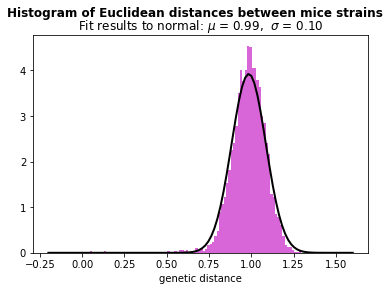

In [35]:
ax = plt.subplot()
plt.suptitle("Histogram of Euclidean distances between mice strains", fontweight='bold')
strain_gen_dist_series = pd.Series(strain_genetic_dist.flatten())
hist_norm_fit(strain_gen_dist_series, ax, meth=norm, bins=100)
ax.set_xlabel("genetic distance")
plt.show()

<div class="alert alert-block alert-info">
    Once we mask the peak below 90, the distances genetic distance between strains looks like a gaussian distribution. Still need to investigate where does this ~90 pick comes from.
</div>

#### Unweighted edges

In [44]:
# Here we take mean distance value when we don't mask over 90
mean_dist = strain_genetic_dist.mean()
std_dist = strain_genetic_dist.std()
print("Mean pairwise distance: %0.2f (+/- %0.2f)" % (strain_genetic_dist.mean(), strain_genetic_dist.std()))

Mean pairwise distance: 0.99 (+/- 0.10)


Let's create adjacency matrix for the strains by thresholding the Euclidean distance matrix.
The resulting **unweighted** adjacency matrix should have entries


$$ A_{ij} = \begin{cases} 1, \; \text{if} \; d(i,j)< \mathbb{E}[D], \; i \neq j, \\ 0, \; \text{otherwise.} \end{cases} $$


In [45]:
#Algorithm to create the edges
threshold = mean_dist

gen_related_strain_A = squareform(strain_genetic_dist)
gen_related_strain_A = np.where(gen_related_strain_A < threshold, 1, 0)
gen_related_strain_A -= np.identity(gen_related_strain_A.shape[0], dtype='int64')
gen_related_strain_A.shape

(93, 93)

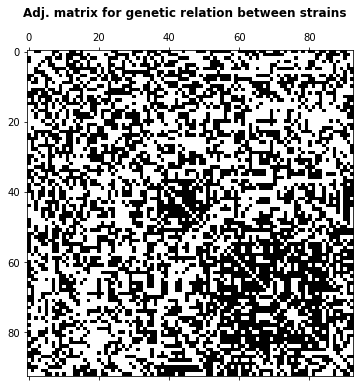

In [46]:
plt.figure(figsize=(6, 6))
plt.spy(gen_related_strain_A)
plt.suptitle("Adj. matrix for genetic relation between strains", fontweight='bold')
plt.show()

In [47]:
np.save("data/numpy/gen_related_strain_A.npy", gen_related_strain_A)

#### Weighted edges

In [24]:
def epsilon_similarity_graph(X: np.ndarray, metric='euclidean', sigma=1, epsilon=0):
    """ X (n x d): coordinates of the n data points in R^d.
        sigma (float): width of the kernel
        epsilon (float): threshold
        Return:
        adjacency (n x n ndarray): adjacency matrix of the graph.
    """
    Dists = squareform(pdist(X,metric = "euclidean"))
    Dists = np.exp(-Dists**2/(2 * sigma**2))
    Dists[Dists <= epsilon] = 0
    np.fill_diagonal(Dists,0)
    return Dists

In [25]:
def compute_typical_distance(X,k = 5):
    """ Average distance of the k nearest neighbours for all points
    
    Args:
        X: numpy array of data points.
        k: number of neighbours
        
    Returns:
        mean_top: average distance of the k nearest neighbour
    
    """
    squ_norm = lambda x: x.T @ x
    mega_top = []
    for i,x1 in enumerate(X):
        top = []
        for j,x2 in enumerate(X):
            if (j != i):
                top.append(squ_norm(x1-x2))
        top = np.sort(top)[:k]
        mega_top.append(top)
    mean_top = np.mean(mega_top)
    return mean_top

In [26]:
def plot_distrib(adjacency):
    """ Plot the density of kerneled distances
    
    Args: 
        adjacency (np.array): adjacency matrix
        
    """
    non_zero = adjacency[np.nonzero(adjacency)]
    print("{:0.2f} % of the original data is kept".format(non_zero.size / adjacency.size * 100))
    plt.plot(np.sort(non_zero)[::-1])

In [6]:
gene_expression_df = pd.read_pickle("data/pickle/gene_expr.pkl")
signal = pd.read_pickle("data/pickle/top_variance_genes.pkl")
signal = gene_expression_df[signal.index]

In [97]:
typical_dist = compute_typical_distance(genotype_gene_expression_present_df.values, k=1)
typical_dist

9313.21505376344

In [ ]:
typical_dist-6300

In [27]:
adjacency = epsilon_similarity_graph(genotype_gene_expression_present_df.values, metric='cosine', sigma=70, epsilon=0.25)

27.43 % of the original data is kept


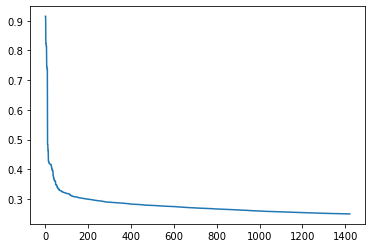

In [28]:
plot_distrib(adjacency)

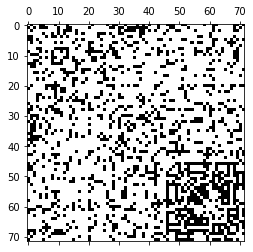

In [29]:
plt.spy(adjacency)
plt.show()

In [161]:
np.save("data/numpy/weighted_adjacency.npy", adjacency) 

# Exploration

## Gene graph

In [129]:
# Loading adjacency matrix
A_genes = np.load("data/numpy/gen_related_strain_A.npy")
gene_graph = nx.from_numpy_array(A_genes)

/Users/Raphael/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


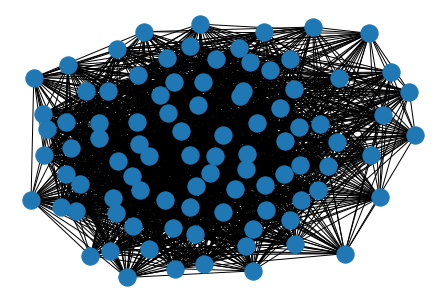

In [130]:
nx.draw(gene_graph)

### Basic statistics

In [131]:
from tabulate import tabulate
def graph_basic_stats(G):
    nodes_number = G.number_of_nodes()
    edges_number = G.number_of_edges()

    g_degree = G.degree()
    sum_degree = sum(dict(g_degree).values())
    average_degree = sum_degree / nodes_number

    tab = [
        ["Number of nodes", nodes_number],
        ["Number of edges", edges_number],
        ["Graph density", round(nx.classes.function.density(G) * 100, 2)],
        ["Average degree", round(average_degree, 2)],
        ["Number of connected components", nx.number_connected_components(G)],
        ["Average clustering coefficient", round(nx.average_clustering(G), 2)],
        ["Diameter of the network (longest shortest path)", nx.diameter(G)]   
    ]
    print(tabulate(tab, tablefmt='fancy_grid'))
    
graph_basic_stats(gene_graph)

╒═════════════════════════════════════════════════╤═════════╕
│ Number of nodes                                 │   93    │
├─────────────────────────────────────────────────┼─────────┤
│ Number of edges                                 │ 2073    │
├─────────────────────────────────────────────────┼─────────┤
│ Graph density                                   │   48.46 │
├─────────────────────────────────────────────────┼─────────┤
│ Average degree                                  │   44.58 │
├─────────────────────────────────────────────────┼─────────┤
│ Number of connected components                  │    1    │
├─────────────────────────────────────────────────┼─────────┤
│ Average clustering coefficient                  │    0.54 │
├─────────────────────────────────────────────────┼─────────┤
│ Diameter of the network (longest shortest path) │    2    │
╘═════════════════════════════════════════════════╧═════════╛


### Degree distribution

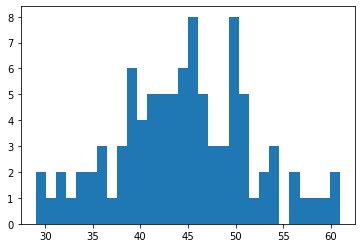

In [132]:
def plot_hist(G, bins=30):
    d = G.degree()
    plt.hist(list(dict(d).values()), bins=bins)
    plt.show()
    
plot_hist(gene_graph)

### Spectral analysis 

#### Eigenvalues & Eigenvectors

In [522]:
adjacency = np.load("data/numpy/weighted_adjacency.npy")

In [523]:
pygsp_weighted_graph = graphs.Graph(adjacency, 'normalized')
nx_weighted_graph = nx.Graph(adjacency)

In [524]:
pygsp_weighted_graph.compute_fourier_basis()

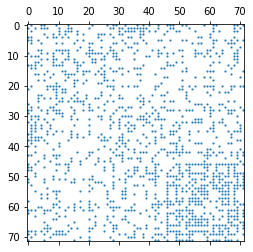

In [135]:
ax = plt.subplot()
ax.spy(pygsp_weighted_graph.W, markersize=1)

/Users/Raphael/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


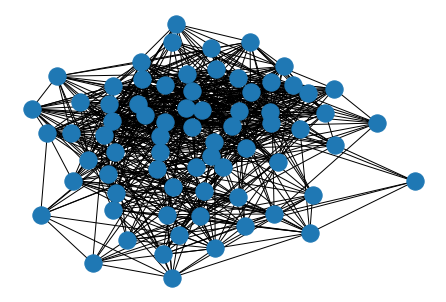

In [136]:
nx.draw(nx_weighted_graph)

In [137]:
graph_basic_stats(nx_weighted_graph)

╒═════════════════════════════════════════════════╤════════╕
│ Number of nodes                                 │  72    │
├─────────────────────────────────────────────────┼────────┤
│ Number of edges                                 │ 711    │
├─────────────────────────────────────────────────┼────────┤
│ Graph density                                   │  27.82 │
├─────────────────────────────────────────────────┼────────┤
│ Average degree                                  │  19.75 │
├─────────────────────────────────────────────────┼────────┤
│ Number of connected components                  │   1    │
├─────────────────────────────────────────────────┼────────┤
│ Average clustering coefficient                  │   0.4  │
├─────────────────────────────────────────────────┼────────┤
│ Diameter of the network (longest shortest path) │   3    │
╘═════════════════════════════════════════════════╧════════╛


In [138]:
# Laplacian
laplacian_matrix = nx.normalized_laplacian_matrix(nx_weighted_graph)
lamb_norm = nx.normalized_laplacian_spectrum(nx_weighted_graph)

Text(0.5, 1.0, 'Eigenvalues $L_{norm}$')

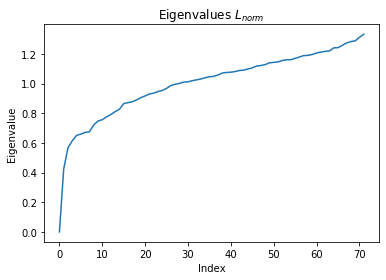

In [139]:
plt.plot(lamb_norm)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{norm}$')

# Exploitation

## Preprocessing

### Labels (hait coat color)

In [59]:
# Build the target
phenotype_df = pd.read_pickle("data/pickle/phenotype.pkl")
y = phenotype_df.loc['X62'].dropna().astype('int64')

### Features

### Find interesting signal

In [126]:
gene_expression_df = pd.read_pickle("data/pickle/gene_expr.pkl")

In [129]:
top_var = 10
top_var_gene = gene_expression_df.std().sort_values().tail(top_var)

In [133]:
gene_expression_df[top_var_gene.index]

gene,Mup2_10513437,Ube2g1_10342768,Mup2_10513455,Mup7_10513420,Ube2g1_10343119,Fbxw11_10375123,Dlg1_10338109,Fbxw11_10375121,H2-Ea-ps_10450161,Mela_10582545
BXD1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BXD100,5.812,7.626,5.791,6.151,8.434,11.691,8.131,11.802,6.517,7.187
BXD101,6.260,5.005,6.183,6.585,4.471,8.518,8.082,8.531,6.810,9.852
BXD11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BXD12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
BXD9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BXD90,6.388,6.113,6.416,6.802,6.107,7.867,4.913,7.899,5.990,10.308
BXD95,5.275,5.385,5.123,5.478,5.612,11.583,5.070,11.735,6.090,9.969
BXD98,6.940,5.482,6.824,7.226,5.587,11.901,7.657,12.044,6.594,9.686


In [134]:
top_var_gene.to_pickle("data/pickle/top_variance_genes.pkl")

### Graph signal processing

In [85]:
lam = pygsp_weighted_graph.e
U = pygsp_weighted_graph.U

In [704]:
gene_expression_df = pd.read_pickle("data/pickle/gene_expr.pkl")
signal = pd.read_pickle("data/pickle/top_variance_genes.pkl")
signal = gene_expression_df[signal.index]
signal.replace({np.nan: 0}, inplace=True)

/Users/Raphael/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/pandas/core/frame.py:4263: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


Text(0, 0.5, 'GFT')

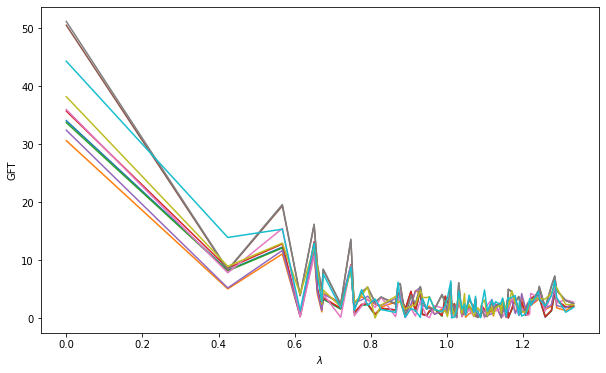

In [87]:
plt.figure(figsize=(10, 6))
for i in range(signal.shape[1]):
    plt.plot(lam, abs(pygsp_weighted_graph.gft(signal.iloc[:, i].values)), '-') 
    
plt.xlabel('$\lambda$')
plt.ylabel('GFT')

In [124]:
sign_filtered = filters.Expwin(pygsp_weighted_graph, bmax=0.8).filter(signal)

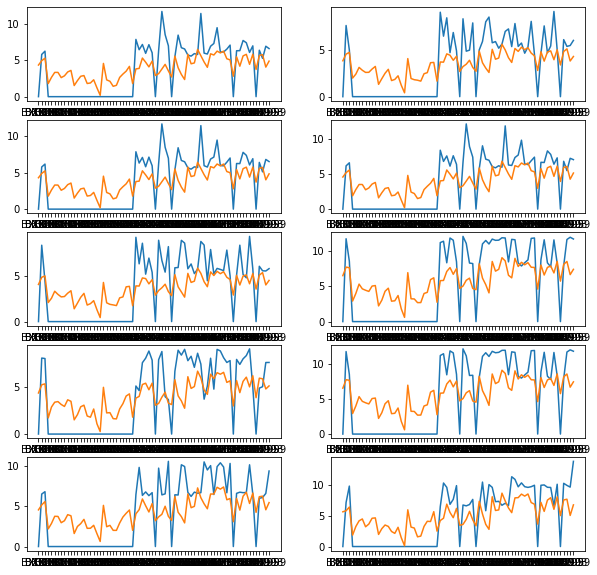

In [125]:
fig, axes = plt.subplots(5, 2, figsize=(10, 10))
for idx, ax in enumerate(axes.flatten()):
    ax.plot(signal.iloc[:,idx])
    ax.plot(sign_filtered[:, idx])

In [126]:
fig.savefig("filtered_signal.png")

### Interpolation error measure

In [755]:
def kfold_interp_error(val, filter_, k=10, test_size=0.1):
    ''' Compute the error of interpolation with kfold for each column of the DataFrame
    
    Args:
        - df (pd.DataFrame): dataframe where rows are mouse strains and column are gene expression
        - filter_ (pygsp.filters): any pygsp filter
        - k (integer): the number of folding for each column
        - test_size (float): percentage of the strains to use as test set for error measurment
    Return:
        - kFold_abs_err_list (list()): the list of k-folded absolute error for each column (gene expression)
    '''
    
    kFold_abs_err_list = []
    
    for i in range(val.shape[1]):
        
        err_list = []
        non_zero_idx = np.where(val[:,i] != 0.)
        for j in range(k):
            s_copy = np.copy(val[:,i])
            idx_test = np.random.choice(non_zero_idx[0], size=int(s.shape[0] * test_size), replace=False)

            np.put(s_copy, idx_test, 0.)

            s_filtered = filter_.filter(s_copy)
            err = val[idx_test,i].sum() - s_filtered[idx_test].sum()
            err_list.append(err)
        
        kFold_abs_err_list.append(np.mean(err_list))
    return kFold_abs_err_list

In [804]:
pygsp_filter = filters.Expwin(pygsp_weighted_graph, bmax=0.8)
%timeit kFold_abs_err_list = kfold_interp_error(signal.values, pygsp_filter, test_size=0.1)

mean_err = np.mean(kFold_abs_err_list)
print("Mean absolute interpolation error for the gene expression: {}".format(mean_err))

561 ms ± 52.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Mean absolute interpolation error for the gene expression: 25.597487932899462


In [779]:
%%time
# find the best parameters for Expwin

mean_err_list = []
for i in np.linspace(0.01, 1.2, num=10):
    pygsp_filter = filters.Expwin(pygsp_weighted_graph, bmax=0.8)
    assess = []
    for j in range(50):
        assess.append(kfold_interp_error(signal.values, pygsp_filter, test_size=0.1))
    
    mean_err_list.append(np.mean(np.mean(assess)))

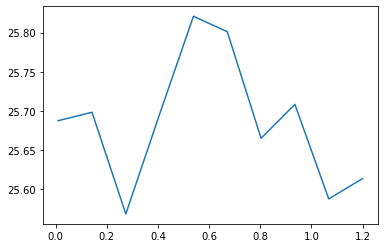

In [781]:
plt.plot(np.linspace(0.01, 1.2, num=10), mean_err_list)

## Baseline